In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 20
IMAGE_SIZE = 28
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_augment"
PATH = ""

In [0]:
rotation_range = 10
width_shift_range = 0.1
height_shift_range = 0.1
brightness_range = (0.5,1.0)
zoom_range = 0.2
horizontal_flip = True

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

#Data generators


In [0]:
datagen_rotation = ImageDataGenerator(rotation_range=rotation_range)
datagen_width_shift = ImageDataGenerator(width_shift_range=width_shift_range)
datagen_height_shift = ImageDataGenerator(height_shift_range=height_shift_range)
datagen_brightness = ImageDataGenerator(brightness_range=brightness_range)
datagen_zoom = ImageDataGenerator(zoom_range=zoom_range)
datagen_hflip = ImageDataGenerator(horizontal_flip=horizontal_flip)

In [0]:
datagens = []
datagens.append(datagen_rotation)
datagens.append(datagen_width_shift)
datagens.append(datagen_brightness)
datagens.append(datagen_zoom)
datagens.append(datagen_hflip)

# Model

In [0]:
def MNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters=16, kernel_size=(3,3), activation='relu',strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=16, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Train

In [25]:
models = []
accuracies = [0]
patience = 0

for i in range(len(datagens)):

    print(f"Train model {i}")

    datagen = datagens[i].flow(x_train,y_train, batch_size = BATCH_SIZE) 
    model = MNISTmodel(IMAGE_SIZE, NUM_CLASSES, 1)

    es = EarlyStopping(min_delta=0.01, patience=3)
    model.fit_generator(datagen,
                        epochs = EPOCHS,
                        validation_data = (x_test,y_test),
                        shuffle = True,
                        callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")

Train model 0
Epoch 1/20
375/375 [==============================] - 14s 37ms/step - loss: 2.3060 - accuracy: 0.1796 - val_loss: 2.2918 - val_accuracy: 0.1156
Epoch 2/20
375/375 [==============================] - 13s 35ms/step - loss: 2.2634 - accuracy: 0.2148 - val_loss: 2.2454 - val_accuracy: 0.2196
Epoch 3/20
375/375 [==============================] - 13s 35ms/step - loss: 2.2235 - accuracy: 0.2421 - val_loss: 2.1940 - val_accuracy: 0.2189
Epoch 4/20
375/375 [==============================] - 13s 36ms/step - loss: 2.1680 - accuracy: 0.2554 - val_loss: 2.1248 - val_accuracy: 0.2413
Epoch 5/20
375/375 [==============================] - 13s 35ms/step - loss: 2.0990 - accuracy: 0.2629 - val_loss: 2.0454 - val_accuracy: 0.2848
Epoch 6/20
375/375 [==============================] - 14s 36ms/step - loss: 2.0286 - accuracy: 0.2781 - val_loss: 1.9718 - val_accuracy: 0.2955
Epoch 7/20
375/375 [==============================] - 13s 35ms/step - loss: 1.9628 - accuracy: 0.2926 - val_loss: 1.9054 -

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Model: 0 added. Resulting score: 0.4608333333333333
Train model 1
Epoch 1/20
375/375 [==============================] - 14s 39ms/step - loss: 2.2860 - accuracy: 0.1705 - val_loss: 2.2767 - val_accuracy: 0.2068
Epoch 2/20
375/375 [==============================] - 14s 37ms/step - loss: 2.2319 - accuracy: 0.2404 - val_loss: 2.2093 - val_accuracy: 0.2332
Epoch 3/20
375/375 [==============================] - 14s 37ms/step - loss: 2.1809 - accuracy: 0.2378 - val_loss: 2.1494 - val_accuracy: 0.2410
Epoch 4/20
375/375 [==============================] - 14s 37ms/step - loss: 2.1225 - accuracy: 0.2536 - val_loss: 2.0796 - val_accuracy: 0.2755
Epoch 5/20
375/375 [==============================] - 14s 37ms/step - loss: 2.0500 - accuracy: 0.2913 - val_loss: 2.0036 - val_accuracy: 0.3088
Epoch 6/20
375/375 [==============================] - 14s 38ms/step - loss: 1.9767 - accuracy: 0.3151 - val_loss: 1.9258 - val_accuracy: 0.3410
Epoch 7/20
375/375 [==============================] - 14s 37ms/step - 

100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Model: 1 added. Resulting score: 0.4488333333333333
Train model 2
Epoch 1/20
375/375 [==============================] - 12s 33ms/step - loss: 2.3571 - accuracy: 0.1065 - val_loss: 2.3240 - val_accuracy: 0.1028
Epoch 2/20
375/375 [==============================] - 12s 32ms/step - loss: 2.2459 - accuracy: 0.1791 - val_loss: 2.3382 - val_accuracy: 0.1135
Epoch 3/20
375/375 [==============================] - 12s 32ms/step - loss: 2.1884 - accuracy: 0.2529 - val_loss: 2.3688 - val_accuracy: 0.1135
Epoch 4/20
375/375 [==============================] - 12s 32ms/step - loss: 2.1238 - accuracy: 0.3082 - val_loss: 2.4232 - val_accuracy: 0.1135


100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


Model: 2 added. Resulting score: 0.3546666666666667
Train model 3
Epoch 1/20
375/375 [==============================] - 13s 35ms/step - loss: 2.3073 - accuracy: 0.0696 - val_loss: 2.2864 - val_accuracy: 0.1131
Epoch 2/20
375/375 [==============================] - 13s 34ms/step - loss: 2.2517 - accuracy: 0.1056 - val_loss: 2.2184 - val_accuracy: 0.1610
Epoch 3/20
375/375 [==============================] - 13s 34ms/step - loss: 2.1900 - accuracy: 0.1983 - val_loss: 2.1315 - val_accuracy: 0.2632
Epoch 4/20
375/375 [==============================] - 13s 34ms/step - loss: 2.1155 - accuracy: 0.2683 - val_loss: 2.0406 - val_accuracy: 0.3271
Epoch 5/20
375/375 [==============================] - 13s 34ms/step - loss: 2.0390 - accuracy: 0.2991 - val_loss: 1.9573 - val_accuracy: 0.3505
Epoch 6/20
375/375 [==============================] - 13s 34ms/step - loss: 1.9707 - accuracy: 0.3040 - val_loss: 1.8810 - val_accuracy: 0.3580
Epoch 7/20
375/375 [==============================] - 13s 34ms/step - 

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Model: 3 added. Resulting score: 0.482
Train model 4
Epoch 1/20
375/375 [==============================] - 4s 12ms/step - loss: 2.2916 - accuracy: 0.1195 - val_loss: 2.2895 - val_accuracy: 0.1223
Epoch 2/20
375/375 [==============================] - 4s 11ms/step - loss: 2.2521 - accuracy: 0.1910 - val_loss: 2.2352 - val_accuracy: 0.2167
Epoch 3/20
375/375 [==============================] - 4s 11ms/step - loss: 2.2015 - accuracy: 0.2598 - val_loss: 2.1705 - val_accuracy: 0.2747
Epoch 4/20
375/375 [==============================] - 4s 10ms/step - loss: 2.1413 - accuracy: 0.3213 - val_loss: 2.1043 - val_accuracy: 0.3437
Epoch 5/20
375/375 [==============================] - 4s 11ms/step - loss: 2.0710 - accuracy: 0.3644 - val_loss: 2.0270 - val_accuracy: 0.3691
Epoch 6/20
375/375 [==============================] - 4s 11ms/step - loss: 1.9845 - accuracy: 0.3710 - val_loss: 1.9328 - val_accuracy: 0.3778
Epoch 7/20
375/375 [==============================] - 4s 11ms/step - loss: 1.9037 - accur

100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

Model: 4 added. Resulting score: 0.48583333333333334


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensemble

In [26]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.000000,0
1,0.460833,1
2,0.448833,2
3,0.354667,3
4,0.482000,4
5,0.485833,5


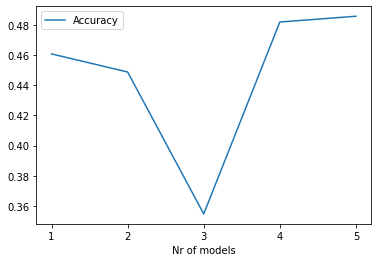

In [27]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [28]:
print("Accuracy: " + str(predict(models, x_test, y_test)))

100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

Accuracy: 0.49


## Correlation between models

In [29]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


In [30]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,0,1,2,3,4
0,NaN,0.516488,NaN,0.508021,0.621802
1,0.516488,NaN,NaN,0.581879,0.502173
2,NaN,NaN,NaN,NaN,NaN
3,0.508021,0.581879,NaN,NaN,0.418016
4,0.621802,0.502173,NaN,0.418016,NaN


Average correlation: 0.5247298697694526
